# Przygotowanie danych i środowiska

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark2.4.5
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# install findspark
!pip install -q findspark
# Google Colab has Java 11 available, test it using below command -
!ls /usr/lib/jvm
#install pyarrow
!pip install -U pyarrow

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 35.4 MB 200 kB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.
db-dtypes 1.0.4 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.


In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_params = {
"spark.executor.memory" : "4g",
"spark.driver.memory": "4g",
"spark.memory.fraction": "0.9"}
for param, value in spark_params.items():
  spark.conf.set(param, value)

!wget "https://datasets.imdbws.com/title.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.ratings.tsv.gz"

title_ratings = spark.read.csv("title.ratings.tsv.gz", sep='\t', header=True)
title_basics = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)

--2022-11-14 20:18:56--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 99.84.160.48, 99.84.160.94, 99.84.160.101, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|99.84.160.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163785676 (156M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 156.20M  46.5MB/s    in 3.4s    

2022-11-14 20:18:59 (45.5 MB/s) - ‘title.basics.tsv.gz’ saved [163785676/163785676]

--2022-11-14 20:19:00--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 99.84.160.48, 99.84.160.94, 99.84.160.101, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|99.84.160.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6265151 (6.0M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz’

title.ratings.tsv.g 100%[===================>]   5.9

In [3]:
print(title_basics.show(5))
print(title_ratings.show(5))

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Union

from scipy.stats import norm
from pyspark.sql.functions import mean, stddev
from pyspark.ml.stat import KolmogorovSmirnovTest

from scipy.stats import pearsonr, chi2_contingency
from scipy.stats.mstats import winsorize

In [5]:
def plot_hist_norm_dist(sample: List[float], m: float, sd: float, 
                        title_lab: Union[str, None], ylim: Union[None, float]):

  x_norm = np.linspace(min(sample), max(sample), 1000)
  y_norm = norm.pdf(x_norm, m, sd)

  plt.plot(x_norm, y_norm, color='red')
  plt.hist(ratings, density=True, bins=50, color='green')
  if ylim is not None:
    plt.ylim(top=ylim)
  plt.title(title_lab)
  plt.show()  

def histogram(sample: List[float], title_lab: Union[str, None]):
  plt.hist(sample, bins=50, color='green')
  plt.title(title_lab)
  plt.show() 

def chi2_test(data_interim: pd.DataFrame, alpha: float = 0.05):
  data_cont = pd.crosstab(data_interim.iloc[:, 0], data_interim.iloc[:, 1])
  stat, p, dof, expected = chi2_contingency(data_cont)

  print("p value jest równa " + str(p))
  if p <= alpha:
      print('Odrzucamy hipoteze H0 o niezależności zmiennych')
  else:
      print('Brak podstaw do odrzucenia hipotezy H0 o niezależności zmiennych')

# Testy normalności 

Przygotwanie odpowiednich wartości liczbowych

In [6]:
excluded_categories = ['\\N', 'Reality-TV', 'Talk-Show', 'Documentary', 
                       'Animation,Comedy,Family', 'Game-Show', 'Game-Show,Reality-TV']

runtime = (title_basics.select('runtimeMinutes').
           filter(~title_basics.runtimeMinutes.isin(excluded_categories)))
runtime = runtime.toPandas()['runtimeMinutes'].astype(float).tolist()

ratings = title_ratings.select('averageRating').toPandas()['averageRating'].astype(float).tolist()

votes = title_ratings.select('numVotes').toPandas()['numVotes'].astype(float).tolist()

In [7]:
ratings_pysp = title_ratings.withColumn("averageRating", 
                                        title_ratings.averageRating.cast('double'))
ratings_pysp = ratings_pysp.withColumn("numVotes", 
                                       ratings_pysp.numVotes.cast('double'))
basic_pysp = title_basics.filter(
    ~title_basics.runtimeMinutes.isin(excluded_categories)
    ).withColumn("runtimeMinutes", title_basics.runtimeMinutes.cast('double'))

Rozkład ocen filmów

Statistic: 0.07652316916295887, p-value: 3.278260995998039e-10
mean: 6.950228122773844, standard deviation: 1.3898674067736088


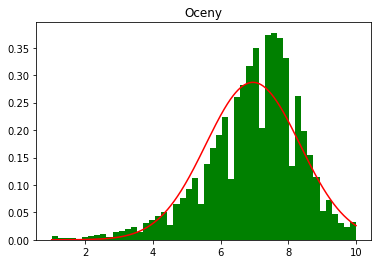

In [8]:
m_r = ratings_pysp.select(mean('averageRating')).collect()[0][0]
sd_r = ratings_pysp.select(stddev('averageRating')).collect()[0][0]

ksResult1 = KolmogorovSmirnovTest.test(ratings_pysp, 'averageRating', 
                                       'norm', m_r, sd_r).first()
p = ksResult1['pValue']
stat = ksResult1['statistic']

print(f'Statistic: {stat}, p-value: {p}')
print(f"mean: {m_r}, standard deviation: {sd_r}")

plot_hist_norm_dist(ratings, m_r, sd_r, 'Oceny', None)

Rozkład liczby ocen

Statistic: 0.4760767950209997, p-value: 2.700628498608637e-09
mean: 1041.8950474958588, standard deviation: 17280.844733605103


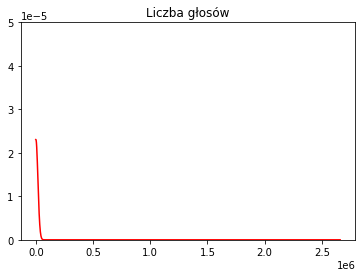

In [9]:
m_v = ratings_pysp.select(mean('numVotes')).collect()[0][0]
sd_v = ratings_pysp.select(stddev('numVotes')).collect()[0][0]

ksResult2 = KolmogorovSmirnovTest.test(ratings_pysp, 'numVotes', 
                                       'norm', m_v, sd_v).first()
p = ksResult2['pValue']
stat = ksResult2['statistic']

print(f'Statistic: {stat}, p-value: {p}')
print(f"mean: {m_v}, standard deviation: {sd_v}")

plot_hist_norm_dist(votes, m_v, sd_v, 'Liczba głosów', 0.00005)

Rozkład czasu trwania

Statistic: 0.29264622160446657, p-value: 2.3206804256048486e-09
mean: 43.79929845930692, standard deviation: 78.43578288580565


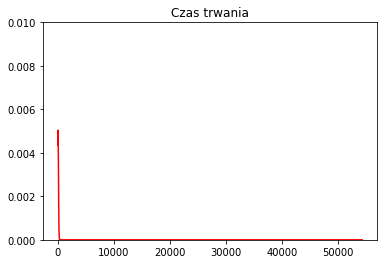

In [10]:
m_t = basic_pysp.select(mean('runtimeMinutes')).collect()[0][0]
sd_t = basic_pysp.select(stddev('runtimeMinutes')).collect()[0][0]

ksResult3 = KolmogorovSmirnovTest.test(basic_pysp, 'runtimeMinutes', 
                                       'norm', m_t, sd_t).first()
p = ksResult3['pValue']
stat = ksResult3['statistic']

print(f'Statistic: {stat}, p-value: {p}')
print(f"mean: {m_t}, standard deviation: {sd_t}")

plot_hist_norm_dist(runtime, m_t, sd_t, 'Czas trwania', 0.01)

Histogramy oraz przeprowadzone testy statystyczne sugerują, że dane nie pochodzą z rozkładu normlanego. Dla liczby ocen oraz czasu trwania wystepują obserwacje które skrajnie różnią się od średniej w danej próbce. Obserwacje te powodują, że p-value dla testów Kolomogorowa-Smirnova jest bliskie zeru.

# Analiza wartości odstających

Usuwamy obserwacje które leża dalej niż 3*odchylenie standardowe od średniej

In [11]:
ratings_cut = [x for x in ratings if (x > m_r - 3 * sd_r) and (x < m_r + 3 * sd_r)]
votes_cut = [x for x in votes if (x > m_v - 3 * sd_v) and (x < m_v + 3 * sd_v)]
runtime_cut = [x for x in runtime if (x > m_t - 3 * sd_t) and (x < m_t + 3 * sd_t)]

In [12]:
print('Liczba outlierów: \n')
print(f'averageRating: {len(ratings) - len(ratings_cut)}\n')
print(f'numVotes: {len(votes) - len(votes_cut)}\n')
print(f'runtimeMinutes: {len(runtime) - len(runtime_cut)}\n')

Liczba outlierów: 

averageRating: 12382

numVotes: 4198

runtimeMinutes: 5020



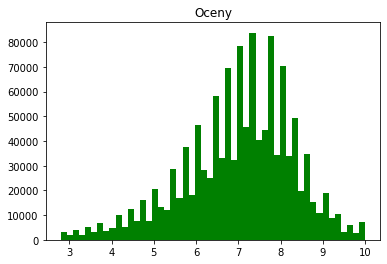

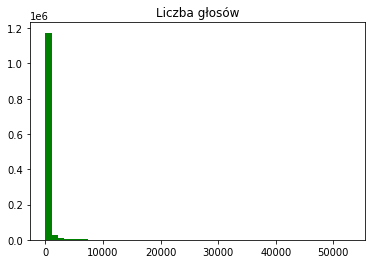

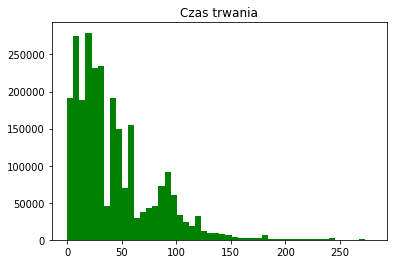

In [13]:
histogram(ratings_cut, 'Oceny')
histogram(votes_cut, 'Liczba głosów')
histogram(runtime_cut, 'Czas trwania')

Widzimy, że dla liczby głosów taka korekta nie jest wystarczająca. Nadal istnieją filmy które posiadają kilka tysięcy ocen, podczas gdy większość filmów ma mnije niż 2500 ocen.

W tej metodzie nie usuwamy wartości skrajnych lecz mapujemy je na wartości kwantyla 1% i 99%.

In [14]:
ratings_win = winsorize(ratings, limits=[0.01, 0.01])
votes_win = winsorize(votes, limits=[0.01, 0.01])
runtime_win = winsorize(runtime, limits=[0.01, 0.01])

In [15]:
print('Liczba outlierów: \n')
print(f'averageRating: {int(0.02 * len(ratings))}\n')
print(f'numVotes: {int(0.02 * len(votes))}\n')
print(f'runtimeMinutes: {int(0.02 * len(runtime))}\n')

Liczba outlierów: 

averageRating: 24955

numVotes: 24955

runtimeMinutes: 51623



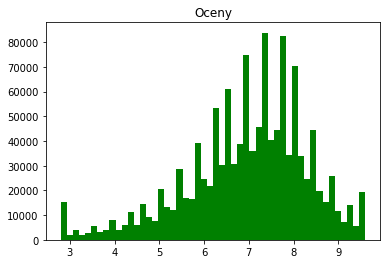

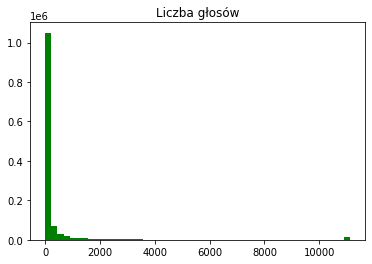

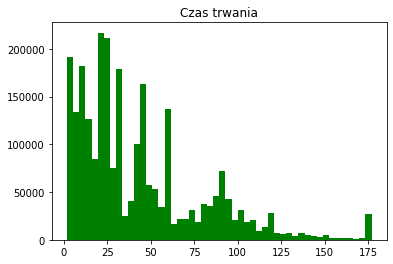

In [16]:
histogram(ratings_win, 'Oceny')
histogram(votes_win, 'Liczba głosów')
histogram(runtime_win, 'Czas trwania')

Metoda może być użyta dla czasu trwania i ocen jednak rozkład liczby głosów  dalej posiada wartości odstające. Prawdopodonie, aby dostać jendorodny rozkład, należałoby podzielić ten zbiór na grupy w zależności od np. regionu lub budżetu filmu.

# Analiza korelacji

In [17]:
data_joined = title_basics.join(title_ratings, 
                                how='inner', 
                                on='tconst')

data = data_joined.select(['averageRating', 'numVotes', 'runtimeMinutes'])
data = data.filter(~data.runtimeMinutes.isin(excluded_categories))
data = data.distinct().toPandas()
data = data.apply(pd.to_numeric)

Macierz korelacji

In [18]:
print(data.corr())

                averageRating  numVotes  runtimeMinutes
averageRating        1.000000  0.031938       -0.054197
numVotes             0.031938  1.000000        0.027261
runtimeMinutes      -0.054197  0.027261        1.000000


Testy istotności dla korelacji

In [19]:
stat1, p1 = pearsonr(data.loc[:, 'numVotes'], data.loc[:, 'averageRating'])
print(f'Statistic: {stat1}, p-value: {p1}')

stat2, p2 = pearsonr(data.loc[:, 'numVotes'], data.loc[:, 'runtimeMinutes'])
print(f'Statistic: {stat2}, p-value: {p2}')

stat3, p3 = pearsonr(data.loc[:, 'runtimeMinutes'], data.loc[:, 'averageRating'])
print(f'Statistic: {stat3}, p-value: {p3}')

Statistic: 0.03193756486552792, p-value: 2.871619456138887e-114
Statistic: 0.027260955910651488, p-value: 9.124529403276511e-84
Statistic: -0.05419695109141859, p-value: 0.0


Macierz korelacji oraz przeprwoadzone testy sugerują brak korelacji między liczbą głosów, średnią oceną i czasem trwania.

# Testy jednorodności

Przegląd danych

In [20]:
data_joined.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|          5.7|    1922|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|          5.8|     259|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|          6.5|    1735|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|  

In [21]:
data = data_joined.select(['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 
                           'averageRating', 'numVotes'])
isadult_count = data.groupBy("isAdult").count()
titletype_count = data.groupBy("titleType").count()

isadult_count.show()
titletype_count.show()

df = data.filter(data.isAdult.isin(['0', '1'])).toPandas()

+-------+-------+
|isAdult|  count|
+-------+-------+
|   2020|      1|
|   2014|      1|
|      0|1228504|
|      1|  19284|
+-------+-------+

+------------+------+
|   titleType| count|
+------------+------+
|    tvSeries| 83555|
|tvMiniSeries| 13986|
|     tvMovie| 48840|
|   tvEpisode|601733|
|       movie|282917|
|   tvSpecial| 10527|
|       video| 47614|
|   videoGame| 13799|
|     tvShort|  2463|
|       short|142356|
+------------+------+



Testy niezależności zmiennych

In [22]:
col1 = ['isAdult', 'titleType']
col2 = ['averageRating', 'runtimeMinutes', 'numVotes']

for c1 in col1:
  for c2 in col2:
    print(f'\n{c1} względem {c2}')
    chi2_test(df[[c1, c2]])


isAdult względem averageRating
p value jest równa 0.0
Odrzucamy hipoteze H0 o niezależności zmiennych

isAdult względem runtimeMinutes
p value jest równa 0.0
Odrzucamy hipoteze H0 o niezależności zmiennych

isAdult względem numVotes
p value jest równa 1.0
Brak podstaw do odrzucenia hipotezy H0 o niezależności zmiennych

titleType względem averageRating
p value jest równa 0.0
Odrzucamy hipoteze H0 o niezależności zmiennych

titleType względem runtimeMinutes
p value jest równa 0.0
Odrzucamy hipoteze H0 o niezależności zmiennych

titleType względem numVotes
p value jest równa 0.0
Odrzucamy hipoteze H0 o niezależności zmiennych


Z wyników testów niezależności Chi^2 możemy wywnioskować, że tylko columny isAdult i numVotes są ze sobą niezależne. W pozostałych przypadkach widzimy zależność statystyczną między wartościamy z kolumn titleType, isAdult z wartościami liczbowymi z kolumn averageRatings, numVotes i runtimeMinutes. 